# Pan-cancer gene prediction using Autoencoders

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
# Load RNAseq data
pancan_rnaseq_df = pd.read_csv('data/pancan_scaled_zeroone_rnaseq.tsv', index_col=0, sep="\t", low_memory=False)
pancan_rnaseq_df.iloc[:2,:5].head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0


In [3]:
# Train Test split
pancan_rnaseq_df_train, pancan_rnaseq_df_test = train_test_split(pancan_rnaseq_df, test_size=0.1, shuffle=True)
pancan_rnaseq_df_train.shape, pancan_rnaseq_df_test.shape

((9413, 5000), (1046, 5000))

In [4]:
# This is the size of our encoded representations
encoding_dim = 100
numb_of_features = pancan_rnaseq_df.shape[1]

# Defining the 'Autoencoder' full model
autoencoder = Sequential()
autoencoder.add(Dense(encoding_dim, activation="relu", input_shape=(numb_of_features, )))
autoencoder.add(Dense(numb_of_features, activation="sigmoid"))
autoencoder.compile(optimizer="adam", loss='mse')
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500100    
                                                                 
 dense_1 (Dense)             (None, 5000)              505000    
                                                                 
Total params: 1,005,100
Trainable params: 1,005,100
Non-trainable params: 0
_________________________________________________________________


2022-10-30 22:10:12.712060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
%%time
hist = autoencoder.fit(np.array(pancan_rnaseq_df_train), np.array(pancan_rnaseq_df_train),
                       shuffle=True,
                       epochs=10,
                       batch_size=50,
                       validation_split=0.2)

Epoch 1/10
151/151 [==============================] - 2s 12ms/step - loss: 0.0268 - val_loss: 0.0175
Epoch 2/10
151/151 [==============================] - 2s 10ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 3/10
151/151 [==============================] - 2s 10ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 4/10
151/151 [==============================] - 2s 10ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 5/10
151/151 [==============================] - 2s 10ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 6/10
151/151 [==============================] - 2s 10ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 7/10
151/151 [==============================] - 1s 10ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 8/10
151/151 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 9/10
151/151 [==============================] - 2s 10ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 10/10
151/151 [==============================] - 2s 10ms/step - loss: 0.0105 - val_lo

Text(0, 0.5, 'Reconstruction Loss')

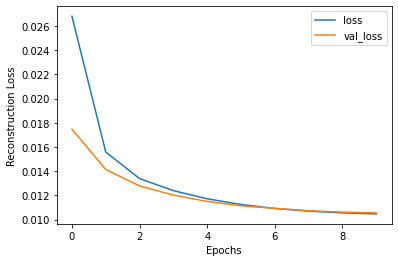

In [6]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('Reconstruction Loss')

In [7]:
input_sample = pancan_rnaseq_df_test[:1]
input_sample

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-BR-8678-01,0.642725,0.074399,0.418074,0.038515,0.602472,0.484442,0.141261,0.616054,0.746804,0.700312,...,0.365411,0.238607,0.714132,0.721601,0.369461,0.53533,0.756406,0.112809,0.218428,0.371805


In [8]:
reconstruction = autoencoder.predict([input_sample])
reconstruction

1/1 [==============================] - 0s 59ms/step


array([[0.54662573, 0.11099564, 0.36999688, ..., 0.07557096, 0.39394298,
        0.4923659 ]], dtype=float32)

In [9]:
# Reconstruct input RNAseq
reconstruction = autoencoder.predict(np.array(pancan_rnaseq_df))

reconstructed_df = pd.DataFrame(reconstruction, index=pancan_rnaseq_df.index,
                                columns=pancan_rnaseq_df.columns)

reconstructed_df.head()

327/327 [==============================] - 1s 3ms/step


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.716592,0.158833,0.164157,0.042706,0.029318,0.045970,0.054415,0.042854,0.736217,0.662835,...,0.471082,0.507990,0.751724,0.678484,0.610952,0.320536,0.405733,0.489534,0.173163,0.627166
TCGA-02-0055-01,0.197564,0.461210,0.243186,0.142398,0.071382,0.161411,0.147527,0.104047,0.163256,0.127440,...,0.566981,0.575176,0.568489,0.638801,0.675789,0.320926,0.498030,0.171139,0.150648,0.648604
TCGA-02-2483-01,0.809183,0.102433,0.137863,0.035753,0.024791,0.044622,0.057372,0.037779,0.794367,0.720939,...,0.383839,0.422220,0.743454,0.470433,0.510058,0.345567,0.425171,0.483378,0.191127,0.586290
TCGA-02-2485-01,0.759603,0.156956,0.138075,0.048427,0.021640,0.034169,0.039846,0.025873,0.765736,0.700537,...,0.458330,0.518129,0.691878,0.654502,0.642431,0.339923,0.439109,0.455744,0.185963,0.656825
TCGA-02-2486-01,0.768964,0.084925,0.125807,0.069192,0.022647,0.041457,0.049400,0.051936,0.739441,0.682629,...,0.618535,0.518452,0.513147,0.590532,0.698707,0.287236,0.448243,0.216072,0.196219,0.643949


In [10]:
reconstruction_fidelity = reconstructed_df - pancan_rnaseq_df

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(pancan_rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.038516,0.238507
GSTT1,-0.001240,0.220185
GSTM1,-0.009530,0.218264
TBC1D3G,-0.006353,0.194752
RPS28,0.015523,0.169935


/Users/ukdevisetty/miniconda3/envs/condon_optimzation/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


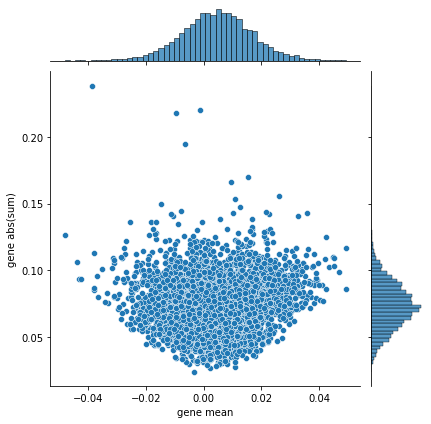

In [11]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary)